In [ ]:
# Fixing pytube code from https://github.com/pytube/pytube/issues/2062
import ssl
from pytube import YouTube
from pytube import request
from pytube import extract
from pytube.innertube import _default_clients
from pytube.exceptions import RegexMatchError

_default_clients["ANDROID"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["IOS"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["ANDROID_EMBED"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["IOS_EMBED"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["IOS_MUSIC"]["context"]["client"]["clientVersion"] = "6.41"
_default_clients["ANDROID_MUSIC"] = _default_clients["ANDROID"]

import pytube, re
def patched_get_throttling_function_name(js: str) -> str:
    function_patterns = [
        r'a\.[a-zA-Z]\s*&&\s*\([a-z]\s*=\s*a\.get\("n"\)\)\s*&&.*?\|\|\s*([a-z]+)',
        r'\([a-z]\s*=\s*([a-zA-Z0-9$]+)(\[\d+\])?\([a-z]\)',
        r'\([a-z]\s*=\s*([a-zA-Z0-9$]+)(\[\d+\])\([a-z]\)',
    ]
    for pattern in function_patterns:
        regex = re.compile(pattern)
        function_match = regex.search(js)
        if function_match:
            if len(function_match.groups()) == 1:
                return function_match.group(1)
            idx = function_match.group(2)
            if idx:
                idx = idx.strip("[]")
                array = re.search(
                    r'var {nfunc}\s*=\s*(\[.+?\]);'.format(
                        nfunc=re.escape(function_match.group(1))),
                    js
                )
                if array:
                    array = array.group(1).strip("[]").split(",")
                    array = [x.strip() for x in array]
                    return array[int(idx)]

    raise RegexMatchError(
        caller="get_throttling_function_name", pattern="multiple"
    )

ssl._create_default_https_context = ssl._create_unverified_context
pytube.cipher.get_throttling_function_name = patched_get_throttling_function_name

# Downloading video
YouTube('https://www.youtube.com/watch?v=l3NJNFmg09k').streams.first().download()

'/workspaces/eng-ai-agents/assignments/assignment-3/Football match.mp4'

In [4]:
# Extracting images code from https://www.geeksforgeeks.org/extract-images-from-video-in-python/
# Importing all necessary libraries
import cv2
import os
# Read the video from specified path
cam = cv2.VideoCapture(os.path.abspath("Football match.mp4"))
try:
    # creating a folder named data
    if not os.path.exists('data'):
        os.makedirs('data')
# if not created then raise error
except OSError:
    print ('Error: Creating directory of data')
currentframe = 0
while(True):
    # reading from frame
    ret,frame = cam.read()
    if ret:
        # if video is still left continue creating images
        name = './data/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name)
        # writing the extracted images
        cv2.imwrite(name, frame)
        # increasing counter so that it will show how many frames are created
        currentframe += 1
    else:
        break
# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

Creating..../data/frame0.jpg
Creating..../data/frame1.jpg
Creating..../data/frame2.jpg
Creating..../data/frame3.jpg
Creating..../data/frame4.jpg
Creating..../data/frame5.jpg
Creating..../data/frame6.jpg
Creating..../data/frame7.jpg
Creating..../data/frame8.jpg
Creating..../data/frame9.jpg
Creating..../data/frame10.jpg
Creating..../data/frame11.jpg
Creating..../data/frame12.jpg
Creating..../data/frame13.jpg
Creating..../data/frame14.jpg
Creating..../data/frame15.jpg
Creating..../data/frame16.jpg
Creating..../data/frame17.jpg
Creating..../data/frame18.jpg
Creating..../data/frame19.jpg
Creating..../data/frame20.jpg
Creating..../data/frame21.jpg
Creating..../data/frame22.jpg
Creating..../data/frame23.jpg
Creating..../data/frame24.jpg
Creating..../data/frame25.jpg
Creating..../data/frame26.jpg
Creating..../data/frame27.jpg
Creating..../data/frame28.jpg
Creating..../data/frame29.jpg
Creating..../data/frame30.jpg
Creating..../data/frame31.jpg
Creating..../data/frame32.jpg
Creating..../data/fr

In [9]:
from typing import Any, Callable, List, Optional, Tuple, Union

import torch
import torch.nn.functional as F
from torch import nn
from torchvision.ops import MultiScaleRoIAlign

from torchvision.ops import misc as misc_nn_ops
from torchvision.transforms._presets import ObjectDetection
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _COCO_CATEGORIES
from torchvision.models._utils import _ovewrite_value_param, handle_legacy_interface
from torchvision.models.mobilenetv3 import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models.resnet import resnet50, ResNet50_Weights
from torchvision.models.detection._utils import overwrite_eps
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.backbone_utils import _mobilenet_extractor, _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.detection.generalized_rcnn import GeneralizedRCNN
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.rpn import RegionProposalNetwork, RPNHead
from torchvision.models.detection.transform import GeneralizedRCNNTransform

def _default_anchorgen():
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    return AnchorGenerator(anchor_sizes, aspect_ratios)

class TwoMLPHead(nn.Module):
    def __init__(self, in_channels, representation_size):
        super().__init__()

        self.fc6 = nn.Linear(in_channels, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x

class FastRCNNConvFCHead(nn.Sequential):
    def __init__(
        self,
        input_size: Tuple[int, int, int],
        conv_layers: List[int],
        fc_layers: List[int],
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ):
        in_channels, in_height, in_width = input_size

        blocks = []
        previous_channels = in_channels
        for current_channels in conv_layers:
            blocks.append(misc_nn_ops.Conv2dNormActivation(previous_channels, current_channels, norm_layer=norm_layer))
            previous_channels = current_channels
        blocks.append(nn.Flatten())
        previous_channels = previous_channels * in_height * in_width
        for current_channels in fc_layers:
            blocks.append(nn.Linear(previous_channels, current_channels))
            blocks.append(nn.ReLU(inplace=True))
            previous_channels = current_channels

        super().__init__(*blocks)
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, mode="fan_out", nonlinearity="relu")
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

class FastRCNNPredictor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        if x.dim() == 4:
            torch._assert(
                list(x.shape[2:]) == [1, 1],
                f"x has the wrong shape, expecting the last two dimensions to be [1,1] instead of {list(x.shape[2:])}",
            )
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

_COMMON_META = {
    "categories": _COCO_CATEGORIES,
    "min_size": (1, 1),
}

class FasterRCNN_ResNet50_FPN_Weights(WeightsEnum):
    COCO_V1 = Weights(
        url="https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth",
        transforms=ObjectDetection,
        meta={
            **_COMMON_META,
            "num_params": 41755286,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/detection#faster-r-cnn-resnet-50-fpn",
            "_metrics": {
                "COCO-val2017": {
                    "box_map": 37.0,
                }
            },
            "_ops": 134.38,
            "_file_size": 159.743,
            "_docs": """These weights were produced by following a similar training recipe as on the paper.""",
        },
    )
    DEFAULT = COCO_V1

class FasterRCNN(GeneralizedRCNN):
    def __init__(
        self,
        backbone,
        num_classes=None,
        # transform parameters
        min_size=800,
        max_size=1333,
        image_mean=None,
        image_std=None,
        # RPN parameters
        rpn_anchor_generator=None,
        rpn_head=None,
        rpn_pre_nms_top_n_train=2000,
        rpn_pre_nms_top_n_test=1000,
        rpn_post_nms_top_n_train=2000,
        rpn_post_nms_top_n_test=1000,
        rpn_nms_thresh=0.7,
        rpn_fg_iou_thresh=0.7,
        rpn_bg_iou_thresh=0.3,
        rpn_batch_size_per_image=256,
        rpn_positive_fraction=0.5,
        rpn_score_thresh=0.0,
        # Box parameters
        box_roi_pool=None,
        box_head=None,
        box_predictor=None,
        box_score_thresh=0.05,
        box_nms_thresh=0.5,
        box_detections_per_img=100,
        box_fg_iou_thresh=0.5,
        box_bg_iou_thresh=0.5,
        box_batch_size_per_image=512,
        box_positive_fraction=0.25,
        bbox_reg_weights=None,
        **kwargs,
    ):

        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)"
            )

        if not isinstance(rpn_anchor_generator, (AnchorGenerator, type(None))):
            raise TypeError(
                f"rpn_anchor_generator should be of type AnchorGenerator or None instead of {type(rpn_anchor_generator)}"
            )
        if not isinstance(box_roi_pool, (MultiScaleRoIAlign, type(None))):
            raise TypeError(
                f"box_roi_pool should be of type MultiScaleRoIAlign or None instead of {type(box_roi_pool)}"
            )

        if num_classes is not None:
            if box_predictor is not None:
                raise ValueError("num_classes should be None when box_predictor is specified")
        else:
            if box_predictor is None:
                raise ValueError("num_classes should not be None when box_predictor is not specified")

        out_channels = backbone.out_channels

        if rpn_anchor_generator is None:
            rpn_anchor_generator = _default_anchorgen()
        if rpn_head is None:
            rpn_head = RPNHead(out_channels, rpn_anchor_generator.num_anchors_per_location()[0])

        rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
        rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)

        rpn = RegionProposalNetwork(
            rpn_anchor_generator,
            rpn_head,
            rpn_fg_iou_thresh,
            rpn_bg_iou_thresh,
            rpn_batch_size_per_image,
            rpn_positive_fraction,
            rpn_pre_nms_top_n,
            rpn_post_nms_top_n,
            rpn_nms_thresh,
            score_thresh=rpn_score_thresh,
        )

        if box_roi_pool is None:
            box_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2)

        if box_head is None:
            resolution = box_roi_pool.output_size[0]
            representation_size = 1024
            box_head = TwoMLPHead(out_channels * resolution**2, representation_size)

        if box_predictor is None:
            representation_size = 1024
            box_predictor = FastRCNNPredictor(representation_size, num_classes)

        roi_heads = RoIHeads(
            # Box
            box_roi_pool,
            box_head,
            box_predictor,
            box_fg_iou_thresh,
            box_bg_iou_thresh,
            box_batch_size_per_image,
            box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh,
            box_nms_thresh,
            box_detections_per_img,
        )

        if image_mean is None:
            image_mean = [0.485, 0.456, 0.406]
        if image_std is None:
            image_std = [0.229, 0.224, 0.225]
        transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std, **kwargs)

        super().__init__(backbone, rpn, roi_heads, transform)

def fasterrcnn_resnet50_fpn(
    *,
    weights: Optional[FasterRCNN_ResNet50_FPN_Weights] = None,
    progress: bool = True,
    num_classes: Optional[int] = None,
    weights_backbone: Optional[ResNet50_Weights] = ResNet50_Weights.IMAGENET1K_V1,
    trainable_backbone_layers: Optional[int] = None,
    **kwargs: Any,
) -> FasterRCNN:
    weights = FasterRCNN_ResNet50_FPN_Weights.verify(weights)
    weights_backbone = ResNet50_Weights.verify(weights_backbone)

    if weights is not None:
        weights_backbone = None
        num_classes = _ovewrite_value_param("num_classes", num_classes, len(weights.meta["categories"]))
    elif num_classes is None:
        num_classes = 91

    is_trained = weights is not None or weights_backbone is not None
    trainable_backbone_layers = _validate_trainable_layers(is_trained, trainable_backbone_layers, 5, 3)
    norm_layer = misc_nn_ops.FrozenBatchNorm2d if is_trained else nn.BatchNorm2d

    backbone = resnet50(weights=weights_backbone, progress=progress, norm_layer=norm_layer)
    backbone = _resnet_fpn_extractor(backbone, trainable_backbone_layers)
    model = FasterRCNN(backbone, num_classes=num_classes, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))
        if weights == FasterRCNN_ResNet50_FPN_Weights.COCO_V1:
            overwrite_eps(model, 0.0)

    return model

/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/vscode/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:24<00:00, 6.95MB/s] 


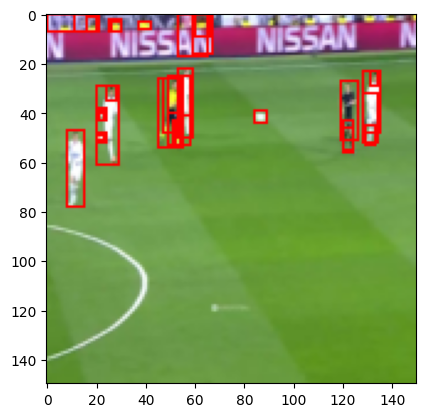

In [11]:
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from PIL import Image
#backbone = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights).features
#backbone.out_channels = 1280
#anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
#roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
#model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights)
model.eval()
test_img = Image.open('data/frame0.jpg')
transform = transforms.Compose([
    torchvision.transforms.Resize((150,150)),
    #torchvision.transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_img = transform(test_img)
x = [test_img, torch.rand(3, 500, 400)]
predictions = model(x)
drawn_boxes = draw_bounding_boxes(x[0], predictions[0]["boxes"], colors="red")
plt.imshow(drawn_boxes.permute(1, 2, 0))